## Authors

| Name     | ID   |
|--------------|----------|
| Devora Cavaleiro     | 20230974    |
| David Guarin     | 20230602   |
| Lia Garcia Henao     | 20230600    |


# Reinforcement Learning Final Project

Welcome to your Reinforcement Learning project! Join in groups of a maximum of 5 students on a project focused on developing an RL agent capable of solving an environment for decision-making in Autonomous Driving. The project deadline has been set to the 2nd of June.

Autonomous Driving has long been considered a field in which RL algorithms excel, and this project aims to leverage the power of RL to create an intelligent agent that can solve the Farama’s foundation “highway-env” project, namely the Highway environment (refer to https://highway-env.farama.org/environments/highway/).

## Project Requirements:

* The environments observation’s format can vary according to our preference, namely Kinematics, Grayscale Image, Occupancy grid and Time to collision (refer to https://highway-env.farama.org/observations/). In your solutions you should use 2 of these types.
* The agents actions can also vary, as continuous actions, discrete actions and discrete meta-actions (refer to https://highway-env.farama.org/actions/). In your solutions you should use 2 of these types.
* As for the algorithms to use, any algorithm is valid (seen or not in class), with a minimum requirement of 3 different algorithms used.
* Apart from the environment observation types and agent action types you must use environment’s configuration provided in the annexed notebook!
Note: Your delivery should comprise 4 solutions to the highway environment (corresponding to the combinations of the two environment observation’s types and the two agent’s action types), in which you just need to use one algorithm for each combination (knowing that you need to use at least 3 different algorithms).


## Project Objectives:

* Train an RL agent to solve the Highway environment: The primary objective of this project is to develop an RL agent that can maximize the reward given by the highway environment (refer to https://highway-env.farama.org/rewards/), which leverages to maximize speed while minimizing crash risk!
* Optimize decision-making using RL algorithms: Explore different RL algorithms to train the agent. Compare and analyse their effectiveness in learning and decision-making capabilities in the context of the environment.
* Explore and expand on the reward system: Although you should evaluate your agent with the reward function provided by the environment, you could/should expand it to better train your agent.
* Enhance interpretability and analysis: Develop methods to analyse the agent's decision-making process and provide insights into its strategic thinking. Investigate techniques to visualize the agent's evaluation of chess positions and understand its reasoning behind specific moves.



### Extra Objectives:

* Investigate transfer learning and generalization: Explore techniques for transfer learning to leverage knowledge acquired in related domains or from pre-training on large chess datasets. Investigate the agent's ability to generalize its knowledge.
* Explore multi agent approaches: The environment allows you to use more than one agent per episode. Explore multi agent alternatives to improve your learning times and overall benchmarks.


## Imports Required

You might need to restart the kernel after installation

In [ ]:
#! pip install highway-env

In [ ]:
#!pip install gymnasium

In [ ]:
#!pip install stable-baselines3[extra]

In [ ]:
import gymnasium as gym

import time
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import time
from pprint import PrettyPrinter

import pandas as pd
from collections import defaultdict

from tqdm.notebook import tqdm


import highway_env #Import the environment that we will use for this exercise
from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy
import random

from itertools import product

## Key Features about the environment
* The environment supports both discrete actions (such as changing lanes) and continuous actions (such as adjusting speed).
* The environment includes a reward structure that can be modified to encourage specific driving behaviors, such as maintaining a safe distance or reaching a destination quickly.

## Steps used in each solution

+ Choose Observation Types: Kinematics, Grayscale Image, Occupancy Grid, and Time to Collision.
+ Choose Action Types: Continuous Actions, Discrete Actions, and Discrete Meta Actions.
+ Implement and evaluate three different reinforcement learning algorithms seen in class.

# Highway-env
### Observation Types

* **Kinematics:** observations provide numerical data about the state of the ego-vehicle (the agent's vehicle) and other surrounding vehicles. So is a structured and precise way for an agent to understand its environment by focusing on the motion-related aspects of both the ego vehicle and surrounding vehicles. This can be particularly useful for tasks that require precise control and understanding of relative dynamics, such as lane-changing and collision avoidance.

* **OccupancyGrid:** the observation is a *W x H x F* array, that represents a grid of shape *W (grid_size) x H (grid_steps)*, discretising the space *(X, Y)* around the ego-vehicle. The F correspond to the features listed.

### Action Types

* **Discrete Actions:** Actions are represented as discrete values, typically corresponding to a finite set of predefined maneuvers. So it simplifies the decision-making process and are easier to implement in some algorithms like DQN. In our example the agent chooses from a set of discrete actions, such as *"change lane left"*, *"accelerate"* or *"brake"*.

* **Discrete Meta-Actions:** In comparison to discrete actions adds a layer of speed and steering controllers on top of the continuous low-level control, so that the ego-vehicle can automatically follow the road at a desired velocity. The meta-actions consist in *changing the target lane and speed* that are used as setpoints for the low-level controllers.






| Action Code | Action     |
|-------------|------------|
| 0           | LANE_LEFT  |
| 1           | IDLE       |
| 2           | LANE_RIGHT |
| 3           | FASTER     |
| 3           | SLOWER     |

### Algorithms
* **DQN:** reinforcement learning algorithm that uses a neural network to approximate the Q-value function, which predicts the expected future rewards for each action in a given state. Only works in environments with discrete action spaces.

* **SARSA:**  on-policy reinforcement learning algorithm that updates the action-value function based on the current state-action pair, the reward received, the next state, and the next action chosen by the policy.

* **Q-Learning:** off-policy reinforcement learning algorithm that seeks to find the optimal action-selection policy by updating the action-value function based on the current state-action pair, the reward received, the maximum estimated future rewards, and the next state, without requiring the action taken by the policy.

## Environment Configuration

Apart from the environment observation types and agent action types you must use some of the environment’s configurations provided bellow!

In [ ]:
def simulated(model, configuration):
    env = gym.make('highway-v0', config=configuration)

    Return = 0
    n_steps = 0
    done = False
    obs, info = env.reset()

    action_counts = np.zeros(env.action_space.n)

    while not done:
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        Return += reward
        n_steps += 1

        action_counts[action] += 1

    env.close()

    return Return, n_steps, action_counts

In [ ]:
 configuration = {

    # Parametrization bellow cannot be changed
    "lanes_count": 10, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
    "observation": {
        "type": "Kinematics"
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction",
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    "collision_reward": -0.5,  # The reward received when colliding with a vehicle. (Can be changed)
    "reward_speed_range": [20,30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 10,  # [Hz] (Can be changed)
    "policy_frequency": 3,  # [Hz] (Can be changed)

    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

## Example Solution
### Solution 0
Environment Observation Type: **Kinematics** \
Agent Action Type: **DiscreteMetaAction** \
Algorithm Used: **Random**

Example of the environment's usage using a random policy.

In [ ]:
env = gym.make('highway-v0', render_mode='human', config=configuration)

obs, info = env.reset(seed=42)
done = truncated = False

Return = 0
n_steps = 1
Episode = 0
while not (done or truncated):
  # Dispatch the observations to the model to get the tuple of actions
  action = env.action_space.sample()
  # Execute the actions
  next_obs, reward, done, truncated, info = env.step(action)
  Return+=reward

  print('Episode: {}, Step: {}, Return: {}'.format(Episode, n_steps, round(Return,2)))
  n_steps+=1
env.close()

Episode: 0, Step: 1, Return: 0.78
Episode: 0, Step: 2, Return: 1.45
Episode: 0, Step: 3, Return: 2.03
Episode: 0, Step: 4, Return: 2.56
Episode: 0, Step: 5, Return: 3.1
Episode: 0, Step: 6, Return: 3.62
Episode: 0, Step: 7, Return: 4.14
Episode: 0, Step: 8, Return: 4.67
Episode: 0, Step: 9, Return: 5.2
Episode: 0, Step: 10, Return: 5.72
Episode: 0, Step: 11, Return: 6.33
Episode: 0, Step: 12, Return: 6.9
Episode: 0, Step: 13, Return: 7.53
Episode: 0, Step: 14, Return: 8.21
Episode: 0, Step: 15, Return: 8.87
Episode: 0, Step: 16, Return: 9.47
Episode: 0, Step: 17, Return: 9.98
Episode: 0, Step: 18, Return: 10.49
Episode: 0, Step: 19, Return: 11.01
Episode: 0, Step: 20, Return: 11.6
Episode: 0, Step: 21, Return: 12.23
Episode: 0, Step: 22, Return: 12.98
Episode: 0, Step: 23, Return: 13.79
Episode: 0, Step: 24, Return: 14.65
Episode: 0, Step: 25, Return: 15.5
Episode: 0, Step: 26, Return: 16.39
Episode: 0, Step: 27, Return: 17.28
Episode: 0, Step: 28, Return: 18.19
Episode: 0, Step: 29, R

### Solution 1
* Environment Observation Type: **Kinematics**
* Agent Action Type: **DiscreteMetaAction**
* Algorithm Used: **DQN**



In [ ]:
configuration = {

    # Parametrization bellow cannot be changed
    "lanes_count": 10, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
    "observation": {
        "type": "Kinematics"
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction",
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    "collision_reward": -0.5,  # The reward received when colliding with a vehicle. (Can be changed)
    "reward_speed_range": [20,30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 10,  # [Hz] (Can be changed)
    "policy_frequency": 3,  # [Hz] (Can be changed)

    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

In [ ]:
# Initialize environment
env = gym.make('highway-v0', render_mode='human', config=configuration)


In [ ]:
# Train model
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=5, progress_bar=True,  tb_log_name="DQN_highway")

env.close()

Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 54.8     |
|    ep_rew_mean      | 40.3     |
|    exploration_rate | 0.74     |
| time/               |          |
|    episodes         | 5        |
|    fps              | 7        |
|    time_elapsed     | 35       |
|    total_timesteps  | 274      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.34     |
|    n_updates        | 43       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 63.4     |
|    ep_rew_mean      | 43.3     |
|    exploration_rate | 0.398    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 7        |
|    time_elapsed     | 83       |
|    total_timesteps  | 634      |
| train/              |        

In [ ]:
# Configuration for offscreen rendering for image capture
capture_configuration = configuration.copy()
capture_configuration["offscreen_rendering"] = True

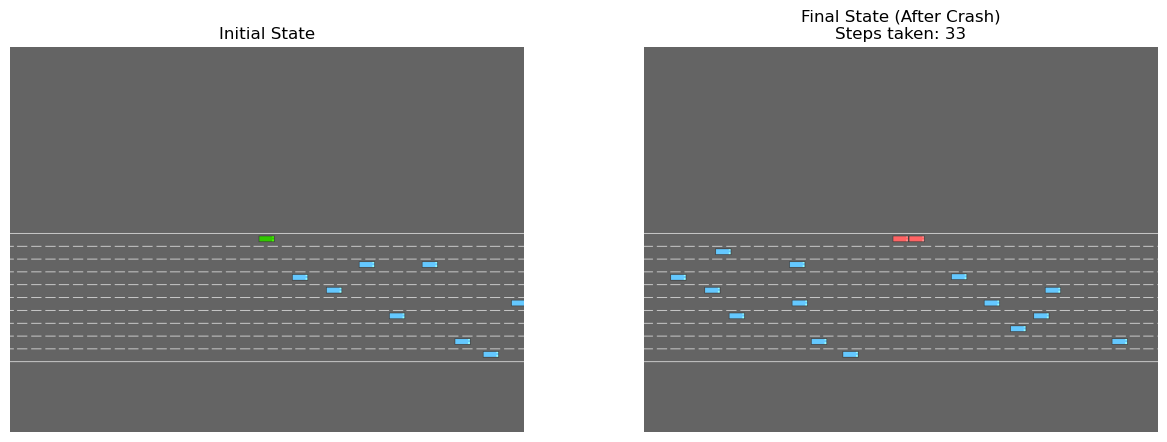

In [ ]:
# Initialize environment with offscreen rendering
env = gym.make('highway-v0', render_mode='rgb_array', config=capture_configuration)

# Capture an image of the environment at the initial state
obs, info = env.reset()
initial_img = env.render()

# Run the environment until done and capture the final image
done = False
steps = 0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    steps += 1

final_img = env.render()

# Plot the initial and final images with step count information
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(initial_img)
ax[0].set_title("Initial State")
ax[0].axis('off')

ax[1].imshow(final_img)
ax[1].set_title(f"Final State (After Crash)\nSteps taken: {steps}")
ax[1].axis('off')

plt.show()

env.close()

### Results with default configuration
* *ep_len_mean:* In the initial episodes, the average episode length is around 11 to 14 actions, which increases slightly over time to around 18 to 21 actions. This could suggest that the agent is exploring more options.
* *ep_rew_mean:* nitially, the average reward per episode is around 9 to 11, which gradually increases to around 13 to 16. This suggests that the agent is learning to achieve higher rewards.
* *exploration_rate:* Indicates the probability of taking a random action instead of following the learned policy. It starts at around 0.458 and decreases gradually to 0.05. This reduction indicates that the agent is shifting from exploration to exploitation as training proceeds.
* *loss:* It starts  at 0.467 and gradually decreases to 0.0645, indicating that the model is improving its performance over time.

### Results with updated configuration

* *ep_len_mean:* the values fluctuate between 35 and 70, so the behavior of the agent it's unstable.
* *ep_rew_mean:* for the initial episodes it ranges between 30 to 45, afterwards it ranges tightly around 40.
* *exploration_rate:* at first it's 0.74 and then ends at 0.05, in this case the agent explores more at the beginning, and then overtime has a preferable tendency to exploit.
* *loss:* It starts with 0.34 and gradually descreases to 0.00943, indicating that the model is improving its performance over time.

In [ ]:
print(model.predict(env.reset()[0])[0] ) # Predict the action to take based on the current observation of the environment using the trained model.

3


### Simulation and Evaluation

In [ ]:
return_value, steps_taken, action_counts = simulated(model, configuration)
rounded_return = round(return_value, 2)
print(f"Total Return: {rounded_return}, Steps Taken: {steps_taken}")

Total Return: 35.88, Steps Taken: 40


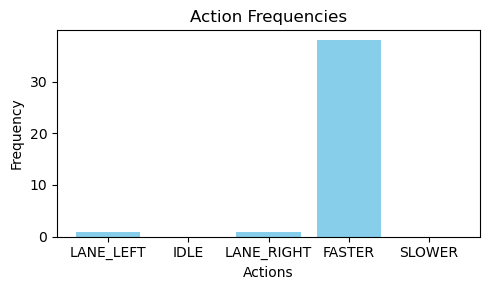

In [ ]:
# Action frequencies
plt.figure(figsize=(5, 3))
plt.bar(actions, action_counts, color='skyblue')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Frequencies')

plt.tight_layout()
plt.show()

In [ ]:
results = [simulated(model, configuration) for _ in range(20)] # Simulate the environment 20 times using the trained model and store the results obtained in a list

df = pd.DataFrame(results, columns=['Return', 'Steps', 'Action Frequencies']) # Create a dataframe with the results obtained from the simulation

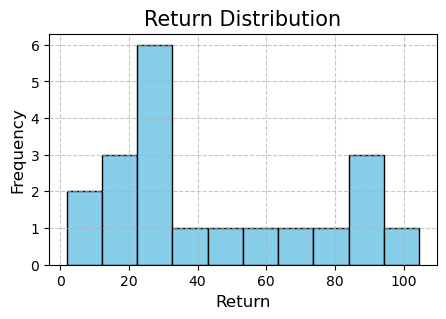

In [ ]:
# Plot the histogram
plt.figure(figsize=(5, 3))
plt.hist(df['Return'], bins=10, color='skyblue', edgecolor='black')
plt.title('Return Distribution', fontsize=15)
plt.xlabel('Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Solution 2
* Environment Observation Type: **OccupancyGrid**
* Agent Action Type: **DiscreteMetaAction**
* Algorithm Used: **DQN**



In [ ]:
configuration = {

    # Parametrization bellow cannot be changed
    "lanes_count": 10, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
   "observation": {
    "type": "OccupancyGrid",
    "vehicles_count": 15,
    "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
    "features_range": {
        "x": [-100, 100],
        "y": [-100, 100],
        "vx": [-20, 20],
        "vy": [-20, 20]
    },
    "grid_size": [[-27.5, 27.5], [-27.5, 27.5]],
    "grid_step": [5, 5],
    "absolute": False
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction",
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    "collision_reward": -0.5,  # The reward received when colliding with a vehicle. (Can be changed)
    "reward_speed_range": [20,30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 10,  # [Hz] (Can be changed)
    "policy_frequency": 3,  # [Hz] (Can be changed)

    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

In [ ]:
# Initialize environment
env = gym.make('highway-v0', render_mode='human', config=configuration)

In [ ]:
# Train model
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=5, progress_bar=True,  tb_log_name="DQN_OccupancyGrid")

env.close()

Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.4     |
|    ep_rew_mean      | 13.7     |
|    exploration_rate | 0.903    |
| time/               |          |
|    episodes         | 5        |
|    fps              | 7        |
|    time_elapsed     | 12       |
|    total_timesteps  | 102      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.4     |
|    ep_rew_mean      | 13.7     |
|    exploration_rate | 0.816    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 7        |
|    time_elapsed     | 25       |
|    total_timesteps  | 194      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 23       |
-------------------------------

In [ ]:
# Configuration for offscreen rendering for image capture
capture_configuration = configuration.copy()
capture_configuration["offscreen_rendering"] = True

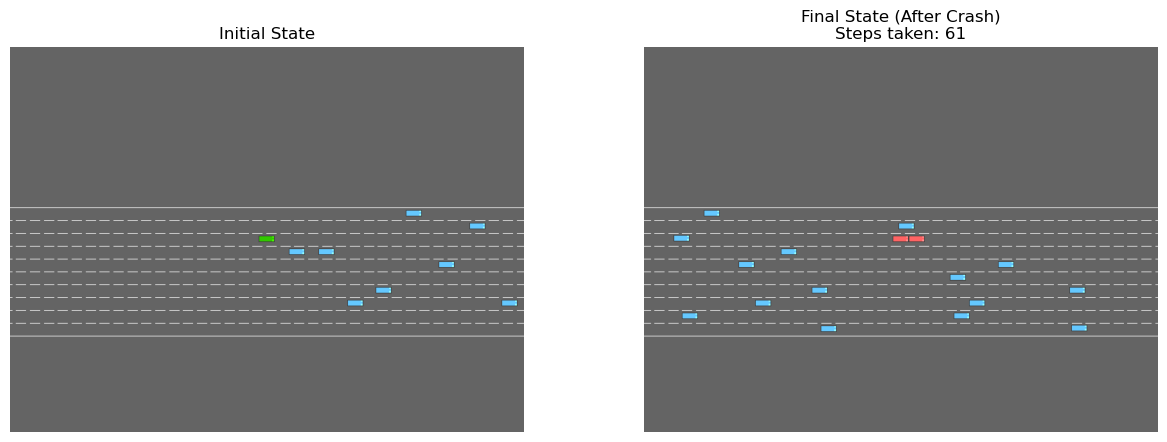

In [ ]:
# Initialize environment with offscreen rendering
env = gym.make('highway-v0', render_mode='rgb_array', config=capture_configuration)

# Capture an image of the environment at the initial state
obs, info = env.reset()
initial_img = env.render()

# Run the environment until done and capture the final image
done = False
steps = 0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    steps += 1

final_img = env.render()

# Plot the initial and final images with step count information
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(initial_img)
ax[0].set_title("Initial State")
ax[0].axis('off')

ax[1].imshow(final_img)
ax[1].set_title(f"Final State (After Crash)\nSteps taken: {steps}")
ax[1].axis('off')

plt.show()

env.close()

### Results with default configuration
* *ep_len_mean:* The average episode length ranges from around 8 to 19 time steps across different episodes.
* *ep_rew_mean:* The average reward per episode ranges from approximately 6 to 15.
* *exploration_rate:* The exploration rate decreases over time, suggesting that the agent shifts from exploration to exploitation as training progresses.
* *loss:* The loss decreases over time, indicating improvement in the model's performance.

### Results with updated configuration
* *ep_len_mean:* The length of the episodes in the beginning ranges between 20 and 30, then gets slightly bigger up to 35.
* *ep_rew_mean:* The average reward per episode ranges from approximatel between 15 and 30.
* *exploration_rate:* The exploration rate decreases over time, from 0.903 to 0.05.
* *loss:* The loss goes from 0.292 to 0.000382, indicating an improvement on performance.

### Simulation and Evaluation

In [ ]:
return_value, steps_taken, action_counts = simulated(model, configuration)
rounded_return = round(return_value, 2)
print(f"Total Return: {rounded_return}, Steps Taken: {steps_taken}")

Total Return: 27.85, Steps Taken: 29


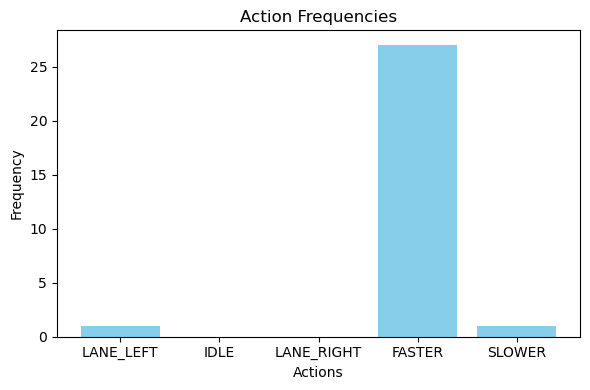

In [ ]:
# Action frequencies
plt.figure(figsize=(6, 4))
plt.bar(actions, action_counts, color='skyblue')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Frequencies')

plt.tight_layout()
plt.show()

In [ ]:
results = [simulated(model, configuration) for _ in range(20)] # Simulate the environment 20 times using the trained model and store the results obtained in a list

df = pd.DataFrame(results, columns=['Return', 'Steps', 'Action Frequencies']) # Create a dataframe with the results obtained from the simulation

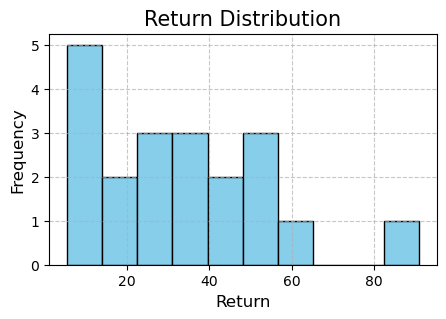

In [ ]:
# Plot the histogram
plt.figure(figsize=(5, 3))
plt.hist(df['Return'], bins=10, color='skyblue', edgecolor='black')
plt.title('Return Distribution', fontsize=15)
plt.xlabel('Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Solution 3
* Environment Observation Type: **Kinematics**
* Agent Action Type: **DiscreteMetaAction**
* Algorithm Used: **Q-Learning**


#### Extra steps
The Q-table's size is determined by the number of states in the observation space and the number of actions in the action space
* Discretize the observation space

In [ ]:
configuration= {

    # Parametrization bellow cannot be changed
    "lanes_count": 10, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
       "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features":  ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order": "sorted"
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction"
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    "collision_reward": -0.5,  # The reward received when colliding with a vehicle. (Can be changed)
    "reward_speed_range": [20,30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 10,  # [Hz] (Can be changed)
    "policy_frequency": 3,  # [Hz] (Can be changed)

    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

#### Q-Learning

In [ ]:
def extract_features(state, feature_indices):
    """Extract the features specified by indices from the state array for the controlled vehicle."""
    controlled_vehicle = state[0]
    return [controlled_vehicle[i] for i in feature_indices]

def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete bins."""
    state_discrete = []
    for feature, feature_bins in zip(state, bins):
        state_discrete.append(np.digitize(feature, feature_bins) - 1)
    return tuple(state_discrete)

def create_bins(observation_config, num_bins=10):
    """Create bins for discretizing the continuous state space."""
    bins = []
    for feature_range in observation_config['features_range'].values():
        bins.append(np.linspace(feature_range[0], feature_range[1], num_bins))
    return bins

def epsilon_greedy_policy(Q_table, state, epsilon, num_actions):
    """Select an action using the epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(Q_table[state])

def Q_learning(env, num_iterations=100, alpha=.85, gamma=.9, epsilon=.65, num_bins=10, log_interval=10):

    # Create bins for discretizing the state space
    bins = create_bins(env.config["observation"], num_bins=num_bins)

    # Initialize Q_table with zeros
    state_space_size = tuple(len(b) for b in bins)
    Q_table = np.zeros(state_space_size + (env.action_space.n,))

    print(f"Action space: {env.action_space}")

    # Define feature indices based on the 'Kinematics' observation type
    feature_indices = list(range(len(env.config["observation"]["features"])))

    episode_rewards = []
    episode_lengths = []
    action_counts = np.zeros(env.action_space.n)  # To track the count of each action

    # For each episode
    for i in tqdm(range(num_iterations)):

        # Initialize the state by resetting the environment
        state = env.reset()
        state_array = state  # Get the state array from the returned tuple
        state_features = extract_features(state_array, feature_indices)
        state_discrete = discretize_state(state_features, bins)

        episode_reward = 0
        episode_length = 0

        num_timesteps = 100  # Reduce episode length to speed up training

        # For each step in the episode:
        for t in range(num_timesteps):

            # Select the action using the epsilon-greedy policy
            action = epsilon_greedy_policy(Q_table, state_discrete, epsilon, env.action_space.n)
            action_counts[action] += 1  # Track the action count

            # Perform the selected action and store the next state information
            next_state, reward, done, truncated, info = env.step(action)
            next_state_array = next_state  # Get the state array from the returned tuple

            next_state_features = extract_features(next_state_array, feature_indices)
            next_state_discrete = discretize_state(next_state_features, bins)

            # Update Q value of the state-action pair
            best_next_action = np.argmax(Q_table[next_state_discrete])
            Q_table[state_discrete + (action,)] += alpha * (reward + gamma * Q_table[next_state_discrete + (best_next_action,)] - Q_table[state_discrete + (action,)])

            # Update next state to current state
            state_discrete = next_state_discrete

            episode_reward += reward
            episode_length += 1

            # Render the environment less frequently to speed up training
            if i % log_interval == 0 and t % 10 == 0:
                env.render()

            # If the current state is the terminal state then break
            if done:
                break

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

        # Logging
        if (i + 1) % log_interval == 0:
            avg_reward = np.mean(episode_rewards[-log_interval:])
            avg_length = np.mean(episode_lengths[-log_interval:])
            print(f"Episode {i + 1}, Avg Reward: {avg_reward}, Avg Length: {avg_length}")

    return Q_table, episode_rewards, episode_lengths, action_counts


In [ ]:
# Initialize environment
env = gym.make('highway-v0', render_mode="human")
env.configure(configuration)
env.reset()

# Define feature indices based on the 'Kinematics' observation type
feature_indices = list(range(len(configuration["observation"]["features"])))

# Q-learning
Q_table, episode_rewards, episode_lengths, action_counts = Q_learning(env, num_iterations=1000, alpha=.85, gamma=.9, epsilon=.65, log_interval=10)
env.close()


Action space: Discrete(5)


C:\Users\joaog\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(
C:\Users\joaog\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 10, Avg Reward: 23.65577120151702, Avg Length: 31.3
Episode 20, Avg Reward: 23.89934730956502, Avg Length: 31.4
Episode 30, Avg Reward: 24.171022892667054, Avg Length: 32.2
Episode 40, Avg Reward: 28.146442734443514, Avg Length: 39.1
Episode 50, Avg Reward: 32.78570792802563, Avg Length: 44.0
Episode 60, Avg Reward: 32.26350223943395, Avg Length: 39.3
Episode 70, Avg Reward: 17.47081978802429, Avg Length: 21.9
Episode 80, Avg Reward: 20.442106561450377, Avg Length: 27.3
Episode 90, Avg Reward: 23.986187804307185, Avg Length: 32.7
Episode 100, Avg Reward: 23.272000735936306, Avg Length: 32.6
Episode 110, Avg Reward: 21.280791610640605, Avg Length: 28.2
Episode 120, Avg Reward: 22.353258261815306, Avg Length: 28.2
Episode 130, Avg Reward: 27.872753296363413, Avg Length: 35.9
Episode 140, Avg Reward: 24.443529991378036, Avg Length: 32.4
Episode 150, Avg Reward: 19.837864399254713, Avg Length: 26.9
Episode 160, Avg Reward: 18.07012553145385, Avg Length: 23.3
Episode 170, Avg Reward

In [ ]:
# Configuration for offscreen rendering for image capture
capture_configuration = configuration.copy()
capture_configuration["offscreen_rendering"] = True

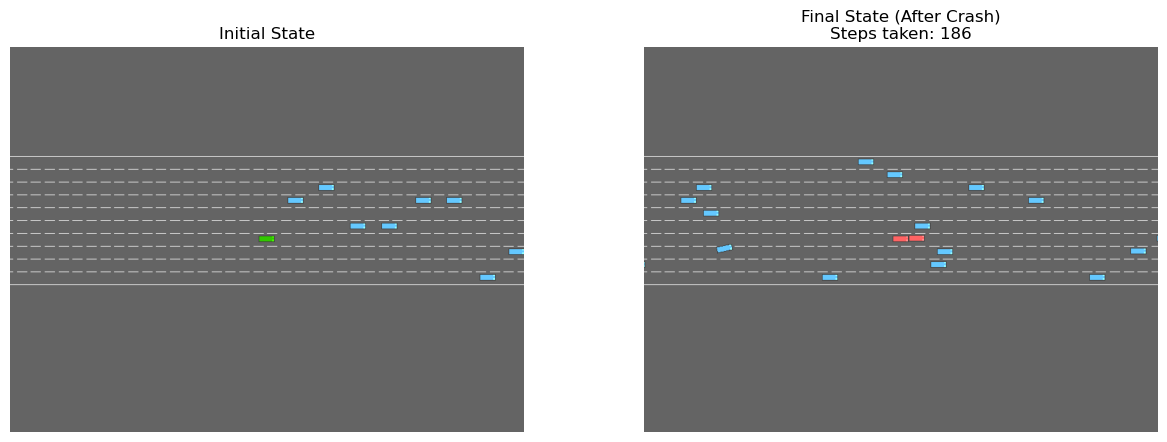

In [ ]:
# Initialize environment with offscreen rendering
env = gym.make('highway-v0', render_mode='rgb_array', config=capture_configuration)

state = env.reset()
initial_img = env.render()  # Capture initial image

done = False
steps = 0
while not done:
    state_features = extract_features(state, feature_indices)
    state_discrete = discretize_state(state_features, create_bins(env.unwrapped.config["observation"]))
    action = np.argmax(Q_table[state_discrete])
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state
    steps += 1

final_img = env.render()  # Capture final image

# Plot the initial and final images with step count information
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(initial_img)
ax[0].set_title("Initial State")
ax[0].axis('off')

ax[1].imshow(final_img)
ax[1].set_title(f"Final State (After Crash)\nSteps taken: {steps}")
ax[1].axis('off')

plt.show()

env.close()

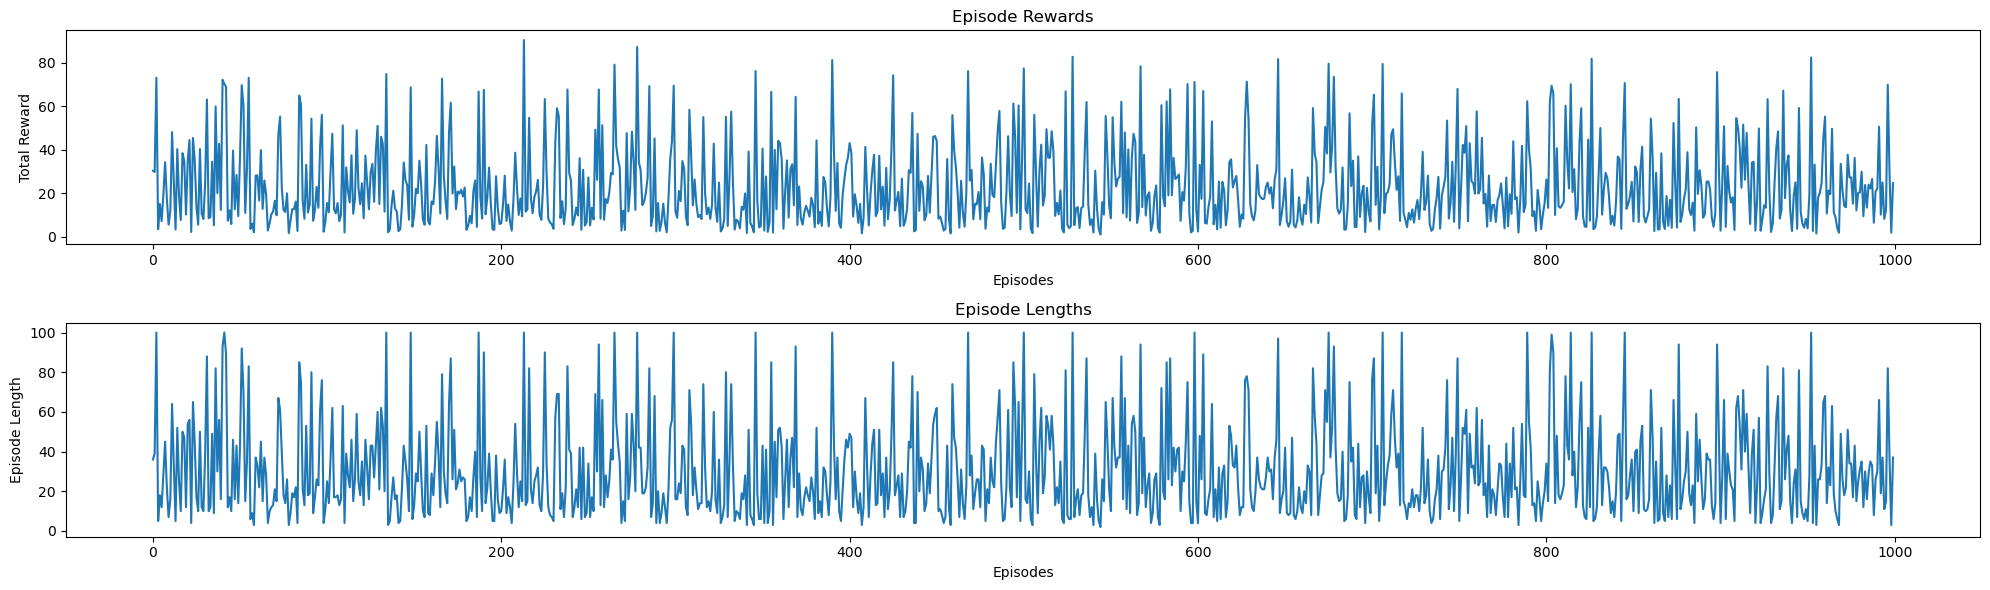

In [ ]:
# Plotting results
# Episode rewards
plt.figure(figsize=(20, 6))
plt.subplot(211)
plt.plot(range(len(episode_rewards)), episode_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Episode Rewards')

# Episode lenght
plt.subplot(212)
plt.plot(range(len(episode_lengths)), episode_lengths)
plt.xlabel('Episodes')
plt.ylabel('Episode Length')
plt.title('Episode Lengths')

plt.tight_layout()
plt.show()

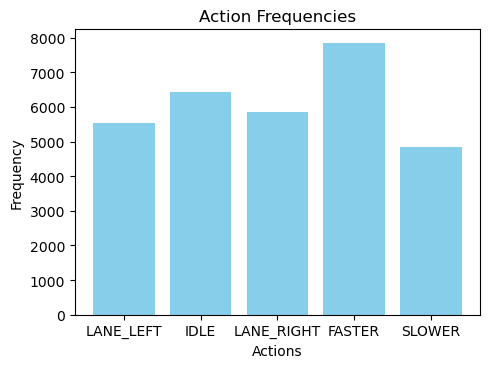

In [ ]:
# Action Frequencies
plt.figure(figsize=(5, 10))
plt.subplot(313)
actions = ['LANE_LEFT', 'IDLE', 'LANE_RIGHT', 'FASTER', 'SLOWER']
plt.bar(actions, action_counts, color='skyblue')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Frequencies')

plt.tight_layout()
plt.show()

### Results with default and updated configurations
* *ep_len_mean:* The rewards are fluctuating mostly between 20 and 80, which indicates that the learning process is not very stable.
* *ep_rew_mean:* The episode lengths are also fluctuating mostly between 20 and 50.

On this configuration the car makes more movements.

### Simulation and Evaluation

In [ ]:
def simulate_q_learning(Q_table, configuration, feature_indices, bins, epsilon=0.05):
    env = gym.make('highway-v0', config=configuration)

    total_return = 0
    n_steps = 0
    done = False
    state = env.reset()
    state_array = state  # Get the state array from the returned tuple
    state_features = extract_features(state_array, feature_indices)
    state_discrete = discretize_state(state_features, bins)

    while not done:
        action = epsilon_greedy_policy(Q_table, state_discrete, epsilon, env.action_space.n)
        next_state, reward, done, truncated, info = env.step(action)
        next_state_array = next_state  # Get the state array from the returned tuple
        next_state_features = extract_features(next_state_array, feature_indices)
        state_discrete = discretize_state(next_state_features, bins)

        total_return += reward
        n_steps += 1

    env.close()
    return total_return, n_steps

In [ ]:
# Create bins for discretizing the state space
bins = create_bins(configuration["observation"])

results = [simulate_q_learning(Q_table, configuration, feature_indices, bins) for _ in range(20)]
df = pd.DataFrame(results, columns=['Return', 'Steps'])

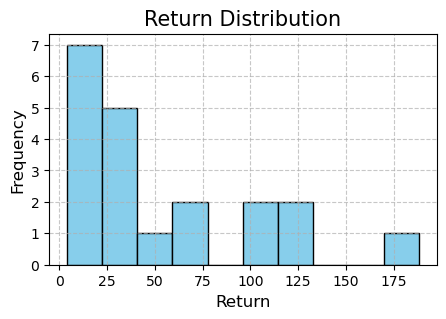

In [ ]:
# Plot the histogram
plt.figure(figsize=(5, 3))
plt.hist(df['Return'], bins=10, color='skyblue', edgecolor='black')
plt.title('Return Distribution', fontsize=15)
plt.xlabel('Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Solution 4
* Environment Observation Type: **OccupancyGrid**
* Agent Action Type: **Discrete Actions**
* Algorithm Used: **SARSA**

### Extra steps
The Q-table's size is determined by the number of states in the observation space and the number of actions in the action space
* Discretize the observation space

In [ ]:
configuration= {

    # Parametrization bellow cannot be changed
    "lanes_count": 10, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 120,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
       "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order": "sorted"
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction"
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    "collision_reward": -0.5,  # The reward received when colliding with a vehicle. (Can be changed)
    "reward_speed_range": [20,30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 10,  # [Hz] (Can be changed)
    "policy_frequency": 3,  # [Hz] (Can be changed)

    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

### SARSA

In [ ]:
def extract_features(state, feature_indices):
    """Extract the features specified by indices from the state array for the controlled vehicle."""
    controlled_vehicle = state[0]
    return [controlled_vehicle[i] for i in feature_indices]

def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete bins."""
    state_discrete = []
    for feature, feature_bins in zip(state, bins):
        state_discrete.append(np.digitize(feature, feature_bins) - 1)
    return tuple(state_discrete)

def create_bins(observation_config, num_bins=10):
    """Create bins for discretizing the continuous state space."""
    bins = []
    for feature_range in observation_config['features_range'].values():
        bins.append(np.linspace(feature_range[0], feature_range[1], num_bins))
    return bins

def epsilon_greedy_policy(Q_table, state, epsilon, num_actions):
    """Select an action using the epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        return np.argmax(Q_table[state])

def SARSA(env, num_iterations=100, alpha=.85, gamma=.9, epsilon=.65, num_bins=10, log_interval=10):

    # Create bins for discretizing the state space
    bins = create_bins(env.config["observation"], num_bins=num_bins)

    # Initialize Q_table with zeros
    state_space_size = tuple(len(b) for b in bins)
    Q_table = np.zeros(state_space_size + (env.action_space.n,))

    print(f"Action space: {env.action_space}")

    feature_indices = list(range(len(env.config["observation"]["features"])))

    episode_rewards = []
    episode_lengths = []
    action_counts = np.zeros(env.action_space.n)  # To track the count of each action

    # For each episode
    for i in tqdm(range(num_iterations)):

        # Initialize the state by resetting the environment
        state = env.reset()
        state_array = state  # Get the state array from the returned tuple
        state_features = extract_features(state_array, feature_indices)
        state_discrete = discretize_state(state_features, bins)

        # Select the initial action
        action = epsilon_greedy_policy(Q_table, state_discrete, epsilon, env.action_space.n)

        episode_reward = 0
        episode_length = 0

        num_timesteps = 100  # Reduce episode length to speed up training

        for t in range(num_timesteps):

            # Track the count of each action
            action_counts[action] += 1

            next_state, reward, done, truncated, info = env.step(action)
            next_state_array = next_state  # Get the state array from the returned tuple
            next_state_features = extract_features(next_state_array, feature_indices)
            next_state_discrete = discretize_state(next_state_features, bins)

            # Select the next action
            next_action = epsilon_greedy_policy(Q_table, next_state_discrete, epsilon, env.action_space.n)

            # Update Q value of the state-action pair
            Q_table[state_discrete + (action,)] += alpha * (reward + gamma * Q_table[next_state_discrete + (next_action,)] - Q_table[state_discrete + (action,)])

            # Update current state and action to next state and action
            state_discrete = next_state_discrete
            action = next_action

            episode_reward += reward
            episode_length += 1

            if i % log_interval == 0 and t % 10 == 0:
                env.render()

            # If the current state is the terminal state then break
            if done:
                break

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

        if (i + 1) % log_interval == 0:
            avg_reward = np.mean(episode_rewards[-log_interval:])
            avg_length = np.mean(episode_lengths[-log_interval:])
            print(f"Episode {i + 1}, Avg Reward: {avg_reward}, Avg Length: {avg_length}")

    return Q_table, episode_rewards, episode_lengths, action_counts


In [ ]:
# Initialize environment
env = gym.make('highway-v0', render_mode="human")
env.configure(configuration)
env.reset()

# Define feature indices based on the 'Kinematics' observation type
feature_indices = list(range(len(configuration["observation"]["features"])))

# SARSA
Q_table, episode_rewards, episode_lengths, action_counts = SARSA(env, num_iterations=1000, alpha=.85, gamma=.9, epsilon=.65, log_interval=10)
env.close()

Action space: Discrete(5)


C:\Users\joaog\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(
C:\Users\joaog\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 10, Avg Reward: 22.809837429836858, Avg Length: 29.5
Episode 20, Avg Reward: 20.69251903577247, Avg Length: 27.1
Episode 30, Avg Reward: 35.426286931807795, Avg Length: 48.9
Episode 40, Avg Reward: 25.393426060442646, Avg Length: 32.7
Episode 50, Avg Reward: 23.236968837554087, Avg Length: 31.6
Episode 60, Avg Reward: 24.93081332191903, Avg Length: 35.2
Episode 70, Avg Reward: 21.26369170560888, Avg Length: 28.4
Episode 80, Avg Reward: 26.79668230580475, Avg Length: 37.9
Episode 90, Avg Reward: 20.916706040881156, Avg Length: 29.0
Episode 100, Avg Reward: 13.66583886671756, Avg Length: 20.1
Episode 110, Avg Reward: 21.074497228010834, Avg Length: 29.2
Episode 120, Avg Reward: 36.11550213427612, Avg Length: 49.5
Episode 130, Avg Reward: 20.497877715059776, Avg Length: 29.4
Episode 140, Avg Reward: 23.125754630493375, Avg Length: 31.7
Episode 150, Avg Reward: 14.646680809903566, Avg Length: 21.4
Episode 160, Avg Reward: 14.459872756875535, Avg Length: 18.7
Episode 170, Avg Reward

In [ ]:
# Configuration for offscreen rendering for image capture
capture_configuration = configuration.copy()
capture_configuration["offscreen_rendering"] = True

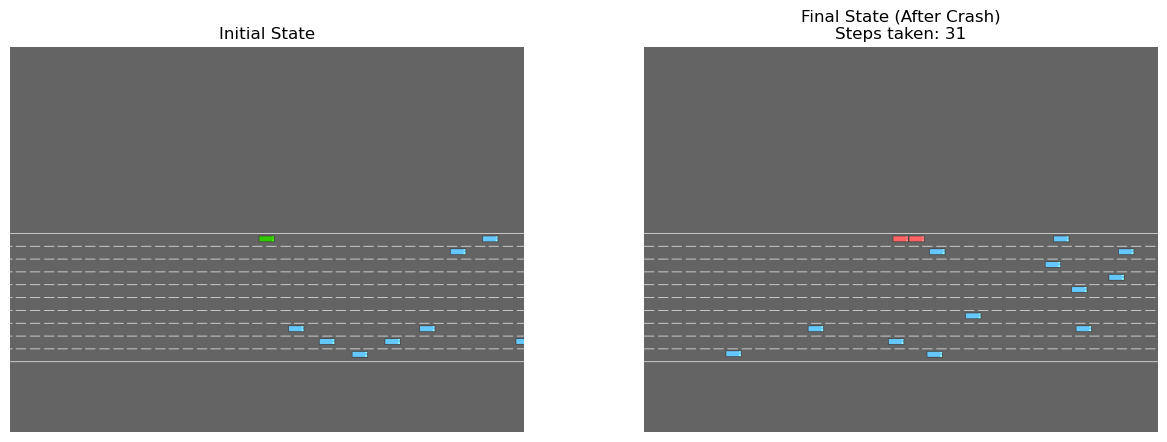

In [ ]:
# Initialize environment with offscreen rendering
env = gym.make('highway-v0', render_mode='rgb_array', config=capture_configuration)

state = env.reset()
initial_img = env.render()  # Capture initial image

done = False
steps = 0
while not done:
    state_features = extract_features(state, feature_indices)
    state_discrete = discretize_state(state_features, create_bins(env.unwrapped.config["observation"]))
    action = np.argmax(Q_table[state_discrete])
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state
    steps += 1

final_img = env.render()  # Capture final image

# Plot the initial and final images with step count information
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(initial_img)
ax[0].set_title("Initial State")
ax[0].axis('off')

ax[1].imshow(final_img)
ax[1].set_title(f"Final State (After Crash)\nSteps taken: {steps}")
ax[1].axis('off')

plt.show()

env.close()

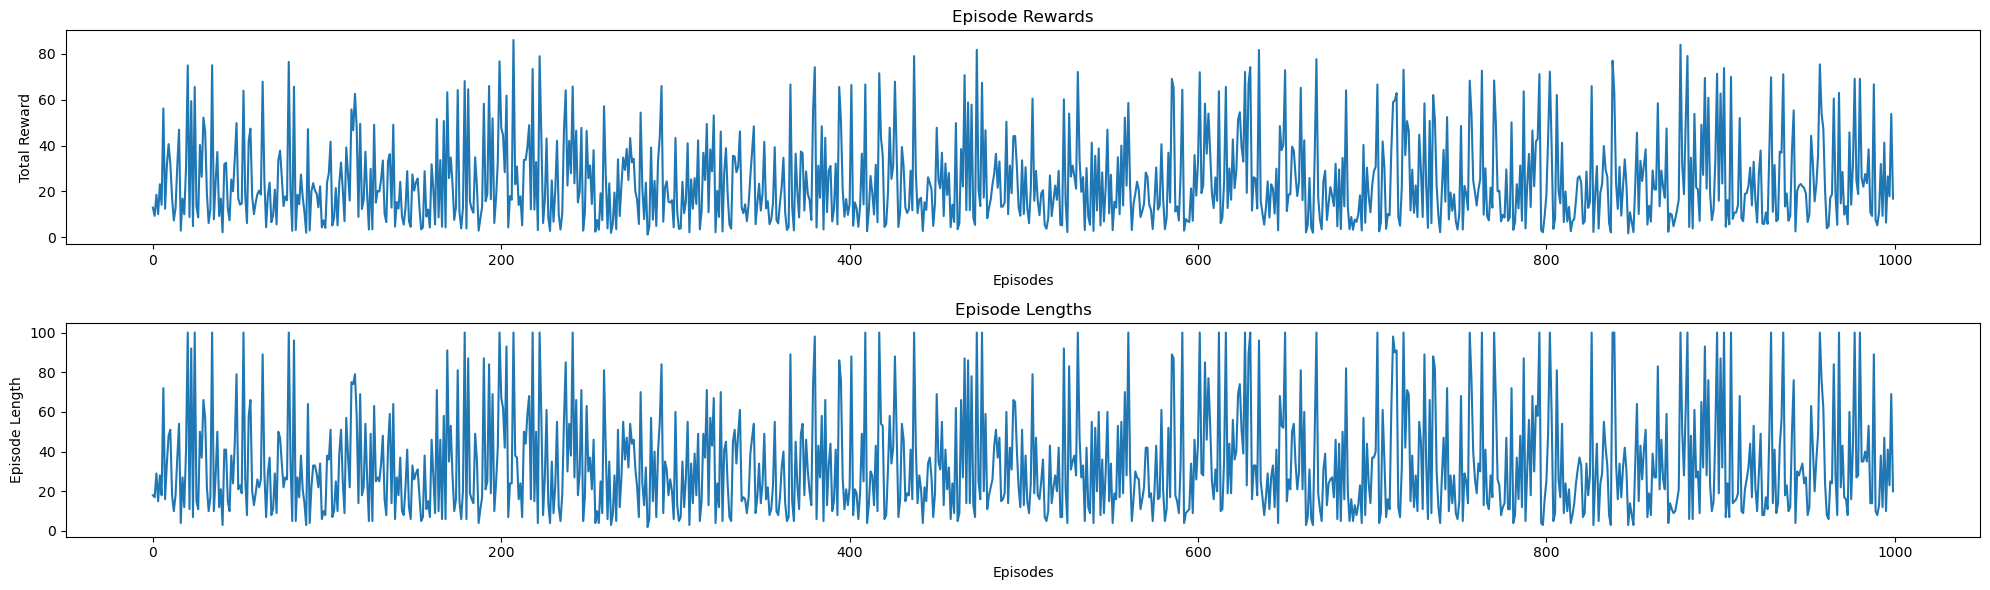

In [ ]:
# Plotting results
# Episode rewards
plt.figure(figsize=(20, 6))
plt.subplot(211)
plt.plot(range(len(episode_rewards)), episode_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Episode Rewards')

# Episode lengths
plt.subplot(212)
plt.plot(range(len(episode_lengths)), episode_lengths)
plt.xlabel('Episodes')
plt.ylabel('Episode Length')
plt.title('Episode Lengths')

plt.tight_layout()
plt.show()

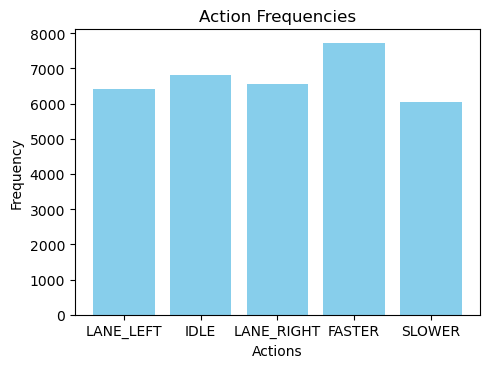

In [ ]:
# Action Frequencies
plt.figure(figsize=(5, 10))
plt.subplot(313)
actions = ['LANE_LEFT', 'IDLE', 'LANE_RIGHT', 'FASTER', 'SLOWER']
plt.bar(actions, action_counts, color='skyblue')
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Frequencies')

plt.tight_layout()
plt.show()

### Results with default and updated configurations
* *ep_len_mean:* The rewards are fluctuating mostly between 30 and 80, which indicates that the learning process is not very stable.
* *ep_rew_mean:* The episode lengths are also fluctuating mostly between 30 and 60.

The car does more movements

### Simulation and Evaluation

In [ ]:
def simulate_sarsa(Q_table, configuration, feature_indices, bins, epsilon=0.05):
    env = gym.make('highway-v0', config=configuration)

    total_return = 0
    n_steps = 0
    done = False
    state = env.reset()
    state_array = state  # Get the state array from the returned tuple
    state_features = extract_features(state_array, feature_indices)
    state_discrete = discretize_state(state_features, bins)

    while not done:
        action = epsilon_greedy_policy(Q_table, state_discrete, epsilon, env.action_space.n)
        next_state, reward, done, truncated, info = env.step(action)
        next_state_array = next_state  # Get the state array from the returned tuple
        next_state_features = extract_features(next_state_array, feature_indices)
        state_discrete = discretize_state(next_state_features, bins)

        total_return += reward
        n_steps += 1

    env.close()
    return total_return, n_steps

In [ ]:
bins = create_bins(configuration["observation"])

results = [simulate_sarsa(Q_table, configuration, feature_indices, bins) for _ in range(20)]
df = pd.DataFrame(results, columns=['Return', 'Steps'])


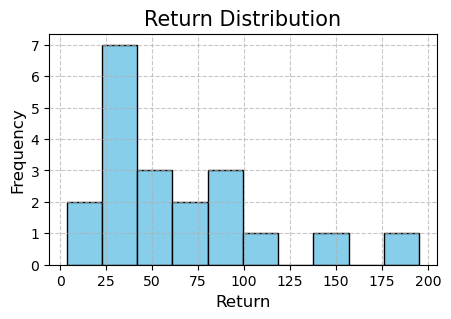

In [ ]:
# Plot the histogram
plt.figure(figsize=(5, 3))
plt.hist(df['Return'], bins=10, color='skyblue', edgecolor='black')
plt.title('Return Distribution', fontsize=15)
plt.xlabel('Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Gridsearch:

We used this technique to try to find the best configuration. The parameters that we tested were the following:
* collision_reward
* reward_speed_range
* simulation_frequency
* policy_frequency

But we only tested for the first configuration since it's very computationally expensive.

The best configuration found was: *'collision_reward'*: -1.0, *'reward_speed_range'*: [15, 25], *'simulation_frequency'*: 15, *'policy_frequency'*: 3

  0%|          | 0/81 [00:00<?, ?it/s]

    collision_reward reward_speed_range  simulation_frequency  \
0               -1.0           [20, 30]                    10   
1               -1.0           [20, 30]                    10   
2               -1.0           [20, 30]                    10   
3               -1.0           [20, 30]                    15   
4               -1.0           [20, 30]                    15   
..               ...                ...                   ...   
76               0.0           [25, 35]                    15   
77               0.0           [25, 35]                    15   
78               0.0           [25, 35]                    20   
79               0.0           [25, 35]                    20   
80               0.0           [25, 35]                    20   

    policy_frequency  avg_return  avg_steps  
0                  1   24.125651       31.5  
1                  2   62.121486       85.9  
2                  3   95.155786      119.6  
3                  1   24.450244   

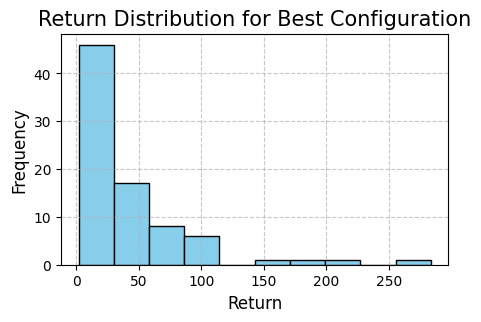

In [ ]:
def simulated(model, configuration, max_steps=1000):
    env = gym.make('highway-v0', config=configuration)

    total_return = 0
    n_steps = 0
    done = False
    obs, info = env.reset()
    while not done and n_steps < max_steps:
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_return += reward
        n_steps += 1
    env.close()
    return total_return, n_steps

# Grid search parameters
collision_rewards = [-1, -0.5, 0]
reward_speed_ranges = [[20, 30], [15, 25], [25, 35]]
simulation_frequencies = [10, 15, 20]
policy_frequencies = [1, 2, 3]

# Store results
grid_search_results = []

# Perform grid search
param_combinations = list(product(collision_rewards, reward_speed_ranges, simulation_frequencies, policy_frequencies))

with tqdm(total=len(param_combinations)) as pbar:
    for collision_reward, reward_speed_range, simulation_frequency, policy_frequency in param_combinations:

        # Update configuration
        configuration = {
            "lanes_count": 10,
            "vehicles_count": 50,
            "duration": 120,
            "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
            "initial_spacing": 2,
            "observation": {
                "type": "Kinematics"
            },
            "action": {
                "type": "DiscreteMetaAction"
            },
            "collision_reward": collision_reward,
            "reward_speed_range": reward_speed_range,
            "simulation_frequency": simulation_frequency,
            "policy_frequency": policy_frequency,
            "screen_width": 800,
            "screen_height": 600,
            "centering_position": [0.5, 0.5],
            "scaling": 5,
            "show_trajectories": False,
            "render_agent": True,
            "offscreen_rendering": False
        }

        # Create and configure the environment
        env = gym.make('highway-v0', render_mode='human', config=configuration)

        try:
            # Train the model
            model = DQN("MlpPolicy", env, verbose=0)
            model.learn(total_timesteps=500, log_interval=5, progress_bar=False, tb_log_name="DQN_highway")
            env.close()

            # Simulate the environment 10 times using the trained model and store the results
            results = [simulated(model, configuration, max_steps=1000) for _ in range(10)]

            # Create a DataFrame with the results
            df = pd.DataFrame(results, columns=['Return', 'Steps'])

            # Compute average return and steps
            avg_return = df['Return'].mean()
            avg_steps = df['Steps'].mean()

            # Store results with the corresponding configuration
            grid_search_results.append({
                'collision_reward': collision_reward,
                'reward_speed_range': reward_speed_range,
                'simulation_frequency': simulation_frequency,
                'policy_frequency': policy_frequency,
                'avg_return': avg_return,
                'avg_steps': avg_steps
            })
        except Exception as e:
            print(f"Error during training or simulation: {e}")
            env.close()
            continue

        pbar.update(1)

# Convert the results to a DataFrame for analysis
grid_search_df = pd.DataFrame(grid_search_results)

# Display the grid search results
print(grid_search_df)

# Plot the histogram for the best configuration
best_config = grid_search_df.loc[grid_search_df['avg_return'].idxmax()]
best_config_params = {
    "collision_reward": best_config['collision_reward'],
    "reward_speed_range": best_config['reward_speed_range'],
    "simulation_frequency": best_config['simulation_frequency'],
    "policy_frequency": best_config['policy_frequency']
}

# Print the best configuration
print("Best Configuration:")
print(best_config_params)

# Plot histogram for the best configuration
plt.figure(figsize=(5, 3))
plt.hist(grid_search_df['avg_return'], bins=10, color='skyblue', edgecolor='black')
plt.title('Return Distribution for Best Configuration', fontsize=15)
plt.xlabel('Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
print(grid_search_df)

    collision_reward reward_speed_range  simulation_frequency  \
0               -1.0           [20, 30]                    10   
1               -1.0           [20, 30]                    10   
2               -1.0           [20, 30]                    10   
3               -1.0           [20, 30]                    15   
4               -1.0           [20, 30]                    15   
..               ...                ...                   ...   
76               0.0           [25, 35]                    15   
77               0.0           [25, 35]                    15   
78               0.0           [25, 35]                    20   
79               0.0           [25, 35]                    20   
80               0.0           [25, 35]                    20   

    policy_frequency  avg_return  avg_steps  
0                  1   24.125651       31.5  
1                  2   62.121486       85.9  
2                  3   95.155786      119.6  
3                  1   24.450244   

In [ ]:
#export the grid search results to a csv file
grid_search_df.to_csv('grid_search_results.csv', index=False)

#export the best configuration parameters to a csv file

best_config_params_df = pd.DataFrame([best_config_params])
best_config_params_df.to_csv('best_config_params.csv', index=False)